# 3MD3220: Reinforcement Learning
# Individual Assignment

### Student: Ibrahim Al Khalil RIDENE
### Student's email: ibrahim-al-khalil.ridene@student-cs.fr

## I. Import Libraries

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import random
from collections import defaultdict
import seaborn as sns
from tqdm import tqdm

# Environment setup 
import text_flappy_bird_gym 

## II. Define Environment

In [ ]:
def make_env(height=15, width=20, pipe_gap=4):
    return gym.make('TextFlappyBird-v0', height=height, width=width, pipe_gap=pipe_gap)

## III.Monte Carlo Agent 

In [ ]:
# Run episodes

def run_episode(env, agent, train=True):
    episode = []
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.policy(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        if train:
            episode.append((state, action, reward))
        state = next_state
        total_reward += reward
        done = terminated or truncated

    return episode, total_reward

In [ ]:
# Monte Carlo agent (First-Visit or Every-Visit)
class MonteCarloAgent:
    def __init__(self, actions, epsilon=0.1, alpha=0.5, gamma=1.0, first_visit=True):
        self.Q = defaultdict(lambda: np.zeros(len(actions)))
        self.returns = defaultdict(list)
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.actions = actions
        self.first_visit = first_visit

    def policy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return np.argmax(self.Q[state])

    def update(self, episode):
        G = 0
        visited = set()
        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = self.gamma * G + r
            if not self.first_visit or (s, a) not in visited:
                self.Q[s][a] += self.alpha * (G - self.Q[s][a])
                visited.add((s, a))

    def train(self, env, episodes=500):
        returns = []
        for _ in range(episodes):
            episode, total_reward = run_episode(env, self)
            self.update(episode)
            returns.append(total_reward)
        return returns

## IV. SARSA(λ) Agent

In [ ]:
# Sarsa(lambda) Agent
class SarsaLambdaAgent:
    def __init__(self, actions, epsilon=0.1, alpha=0.5, gamma=1.0, lambd=0.9):
        self.Q = defaultdict(lambda: np.zeros(len(actions)))
        self.E = defaultdict(lambda: np.zeros(len(actions)))
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.lambd = lambd
        self.actions = actions

    def policy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return np.argmax(self.Q[state])

    def train(self, env, episodes=500):
        rewards = []
        for ep in range(episodes):
            state, _ = env.reset()
            action = self.policy(state)
            self.E = defaultdict(lambda: np.zeros(len(self.actions)))
            total_reward = 0
            done = False

            while not done:
                next_state, reward, terminated, truncated, _ = env.step(action)
                next_action = self.policy(next_state)
                delta = reward + self.gamma * self.Q[next_state][next_action] - self.Q[state][action]
                self.E[state][action] += 1

                for s in self.Q:
                    for a in range(len(self.actions)):
                        self.Q[s][a] += self.alpha * delta * self.E[s][a]
                        self.E[s][a] *= self.gamma * self.lambd

                state = next_state
                action = next_action
                total_reward += reward
                done = terminated or truncated

            rewards.append(total_reward)
        return rewards

## V. Impact of Hyperparameters

## a. Impact of learning rate

In [63]:
# Step size (alpha) sensitivity analysis

def step_size_experiment(agent_type='mc_first', alphas=[0.01, 0.1, 0.5, 1.0], episodes=1000, runs=50, lambd=0.9):
    results = {}
    for alpha in alphas:
        print(f"Running {agent_type} with alpha={alpha}...")
        avg_rewards = np.zeros(episodes)
        for run in tqdm(range(runs)):
            env = make_env(height=6, width=10, pipe_gap=3, screen=False)
            if agent_type == 'mc_first':
                agent = MonteCarloAgent(actions=[0, 1], alpha=alpha, first_visit=True)
            elif agent_type == 'mc_every':
                agent = MonteCarloAgent(actions=[0, 1], alpha=alpha, first_visit=False)
            elif agent_type == 'sarsa_lambda':
                agent = SarsaLambdaAgent(actions=[0, 1], alpha=alpha, lambd=lambd)
            else:
                raise ValueError("Unknown agent_type")

            rewards = agent.train(env, episodes=episodes)
            avg_rewards += np.array(rewards)

        avg_rewards /= runs
        results[alpha] = avg_rewards

    plt.figure(figsize=(10, 6))
    for alpha in results:
        plt.plot(results[alpha], label=f"alpha={alpha}")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title(f"Alpha Sensitivity for {agent_type.replace('_', ' ').title()} Agent")
    plt.legend()
    plt.grid(True)
    plt.show()


Running mc_first with alpha=0.01...


100%|██████████| 50/50 [00:03<00:00, 14.57it/s]


Running mc_first with alpha=0.1...


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


Running mc_first with alpha=0.5...


100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


Running mc_first with alpha=1.0...


100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


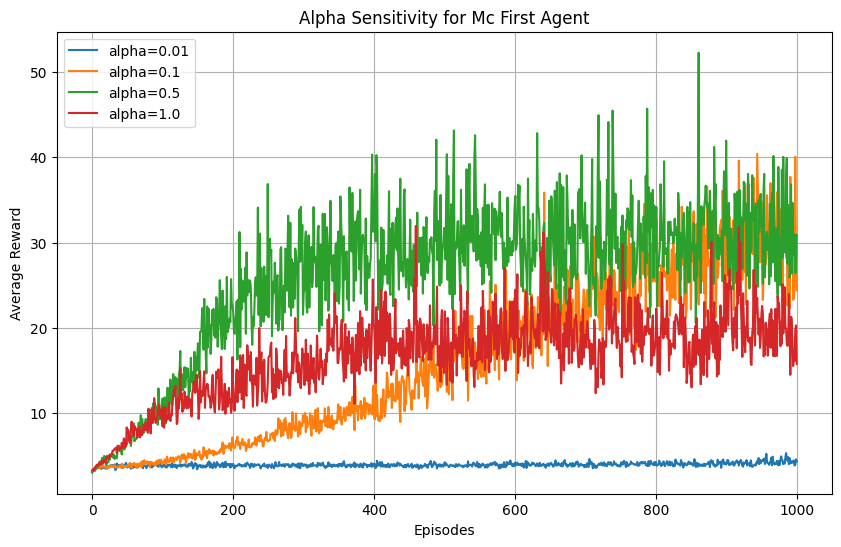

In [ ]:
# MC first visit agent
step_size_experiment(agent_type='mc_first', alphas=[0.01, 0.1, 0.5, 1.0], episodes=1000, runs=50)

The plot above shows how different values of the learning rate parameter `α` affect the learning performance of the **Monte Carlo First-Visit agent** over 1000 episodes.

- **α = 0.01**: Learning is very slow and nearly stagnant. The agent barely improves, indicating underfitting due to very small updates.
- **α = 0.1**: Gradual improvement is visible, but the learning process is still relatively conservative.
- **α = 0.5**: This value results in the highest and most consistent reward across episodes. It provides a strong balance between learning speed and stability.
- **α = 1.0**: Learning is faster in the early stages but becomes unstable with noisy fluctuations in reward, indicating potential overfitting or high variance.

#### ✅ Conclusion:
A moderate learning rate such as **α = 0.5** appears optimal in this setup, offering faster convergence without excessive instability.


Running mc_every with alpha=0.01...


100%|██████████| 50/50 [00:03<00:00, 14.15it/s]


Running mc_every with alpha=0.1...


100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


Running mc_every with alpha=0.5...


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Running mc_every with alpha=1.0...


100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


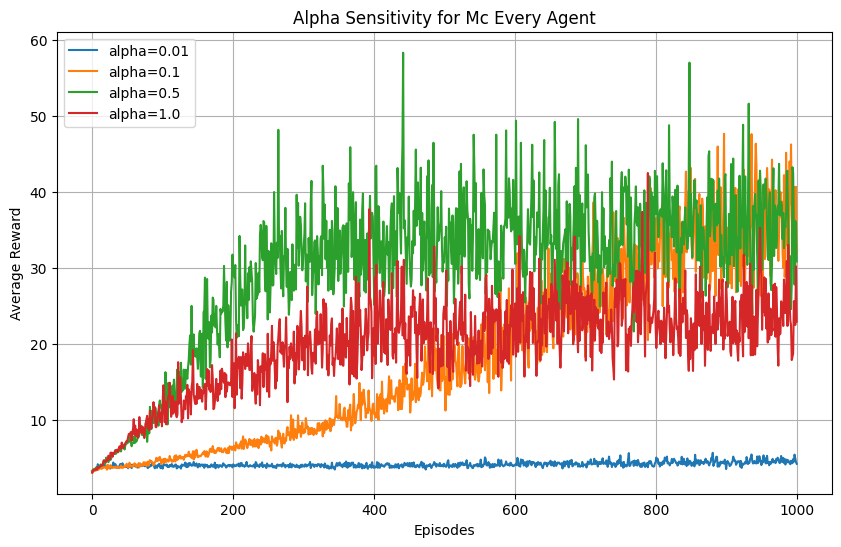

In [ ]:
# MC every visit agent
step_size_experiment(agent_type='mc_every', alphas=[0.01, 0.1, 0.5, 1.0], episodes=1000, runs=50)

#### ✅ Conclusion:
Same as before, A moderate learning rate such as **α = 0.5** appears optimal in this setup, offering faster convergence without excessive instability.

Running sarsa_lambda with alpha=0.01...


100%|██████████| 50/50 [00:13<00:00,  3.74it/s]


Running sarsa_lambda with alpha=0.1...


100%|██████████| 50/50 [00:19<00:00,  2.62it/s]


Running sarsa_lambda with alpha=0.5...


100%|██████████| 50/50 [01:34<00:00,  1.89s/it]


Running sarsa_lambda with alpha=1.0...


100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


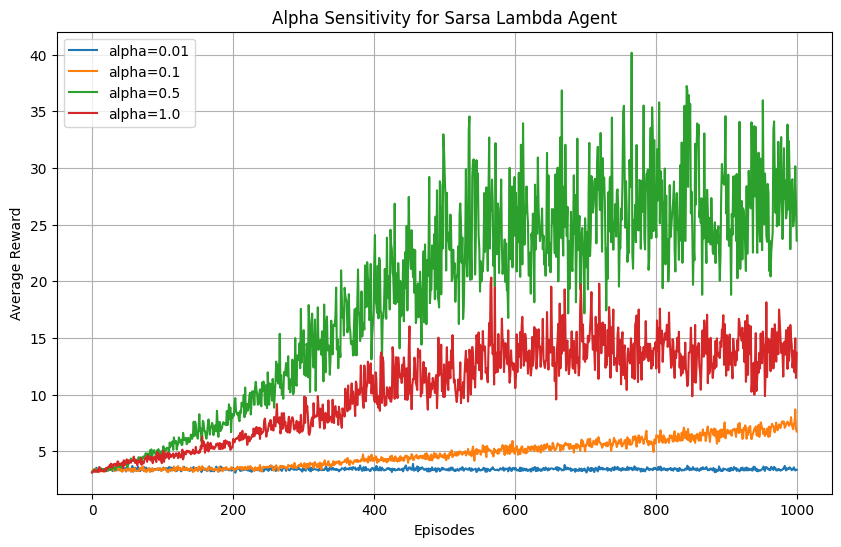

In [ ]:
# Sarsa(0) agent
step_size_experiment(agent_type='sarsa_lambda', alphas=[0.01, 0.1, 0.5, 1.0], episodes=1000, runs=50, lambd=0)

The plot illustrates how different values of the learning rate `α` affect the performance of the **Sarsa(0) agent** over 1000 episodes.

#### ✅ Conclusion:
For `λ = 0`, A moderate learning rate such as **α = 0.5** provides the best trade-off between convergence speed and stability for the Sarsa(0) agent.


Running sarsa_lambda with alpha=0.01...


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


Running sarsa_lambda with alpha=0.1...


100%|██████████| 50/50 [01:36<00:00,  1.93s/it]


Running sarsa_lambda with alpha=0.5...


100%|██████████| 50/50 [03:03<00:00,  3.68s/it]


Running sarsa_lambda with alpha=1.0...


100%|██████████| 50/50 [01:15<00:00,  1.50s/it]


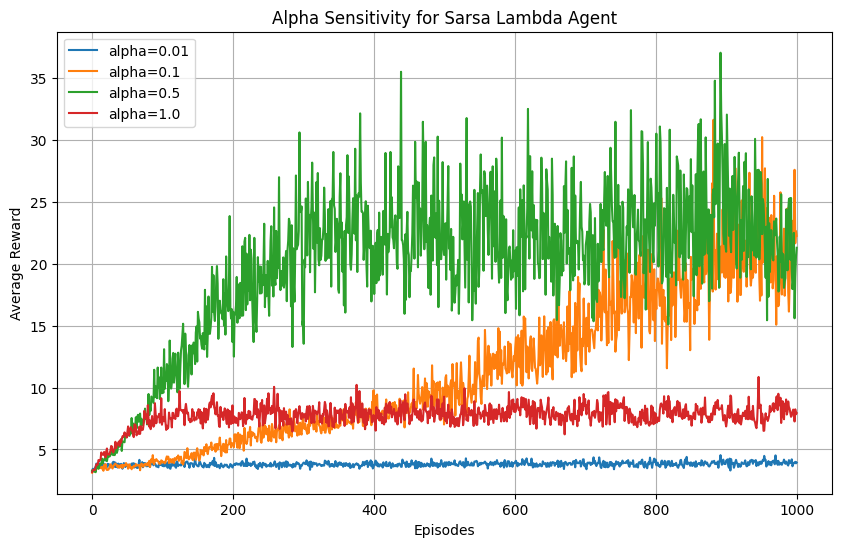

In [ ]:
# Sarsa(0.9) agent
step_size_experiment(agent_type='sarsa_lambda', alphas=[0.01, 0.1, 0.5, 1.0], episodes=1000, runs=50, lambd=0.9)

This plot presents the effect of various learning rates `α` on the performance of the **Sarsa(λ) agent** when the trace decay parameter is fixed at `λ = 0.9`.

#### ✅ Conclusion:
For `λ = 0.9`, a learning rate of **α = 0.5** yields the best balance between fast learning and stability in performance.


## b. Impact of Epsilon (policy)

In [69]:
# Epsilon sensitivity analysis

def epsilon_experiment(agent_type='mc_first', epsilons=[0.0, 0.01, 0.1, 0.4], episodes=1000, runs=50 ,lambd=0.9):
    results = {}
    for epsilon in epsilons:
        print(f"Running {agent_type} with epsilon={epsilon}...")
        avg_rewards = np.zeros(episodes)
        for run in tqdm(range(runs)):
            env = make_env(height=6, width=10, pipe_gap=3, screen=False)
            if agent_type == 'mc_first':
                agent = MonteCarloAgent(actions=[0, 1], epsilon=epsilon, first_visit=True)
            elif agent_type == 'mc_every':
                agent = MonteCarloAgent(actions=[0, 1], epsilon=epsilon, first_visit=False)
            elif agent_type == 'sarsa_lambda':
                agent = SarsaLambdaAgent(actions=[0, 1], epsilon=epsilon, lambd=lambd)
            else:
                raise ValueError("Unknown agent_type")

            rewards = agent.train(env, episodes=episodes)
            avg_rewards += np.array(rewards)

        avg_rewards /= runs
        results[epsilon] = avg_rewards

    plt.figure(figsize=(10, 6))
    for epsilon in results:
        plt.plot(results[epsilon], label=f"epsilon={epsilon}")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title(f"Epsilon Sensitivity for {agent_type.replace('_', ' ').title()} Agent")
    plt.legend()
    plt.grid(True)
    plt.show()

Running mc_first with epsilon=0.0...


100%|██████████| 50/50 [00:04<00:00, 10.58it/s]


Running mc_first with epsilon=0.01...


100%|██████████| 50/50 [00:05<00:00,  8.71it/s]


Running mc_first with epsilon=0.1...


100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


Running mc_first with epsilon=0.4...


100%|██████████| 50/50 [00:20<00:00,  2.39it/s]


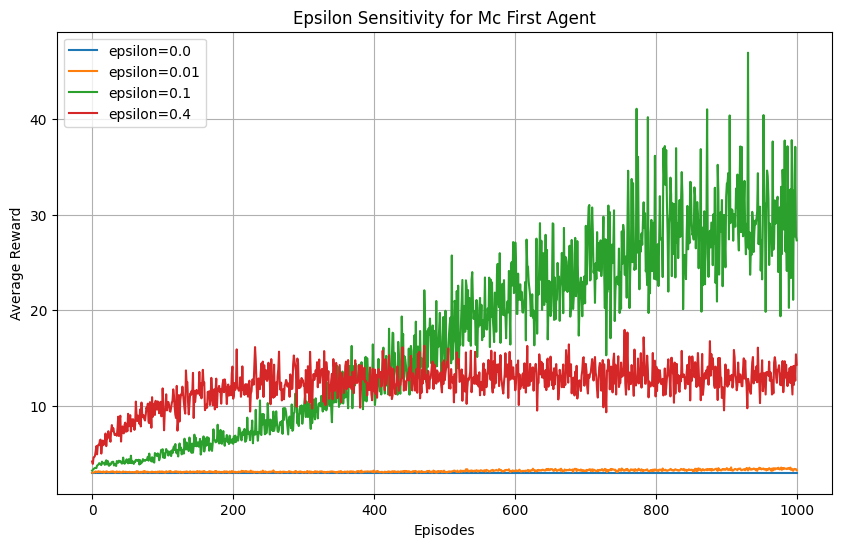

In [ ]:
# MC first visit agent
epsilon_experiment(agent_type='mc_first')

The plot above compares the performance of the **Monte Carlo First-Visit agent** under different exploration rates (ε).

- **ε = 0.0**: With no exploration, the agent completely fails to improve. It gets stuck with initial bad policies and cannot discover better actions.
- **ε = 0.01**: Still performs poorly. Exploration is too minimal to escape suboptimal policies.
- **ε = 0.1**: This value provides the best performance by enabling sufficient exploration to discover high-reward trajectories while still exploiting what it learns.
- **ε = 0.4**: Shows faster early learning than ε=0.1 but plateaus earlier. Too much exploration prevents the agent from fully exploiting good policies.

#### ✅ Conclusion:
An intermediate value like **ε = 0.1** strikes the best balance between exploration and exploitation, leading to the highest and most stable rewards.


Running mc_every with epsilon=0.0...


100%|██████████| 50/50 [00:04<00:00, 11.15it/s]


Running mc_every with epsilon=0.01...


100%|██████████| 50/50 [00:05<00:00,  9.40it/s]


Running mc_every with epsilon=0.1...


100%|██████████| 50/50 [00:14<00:00,  3.41it/s]


Running mc_every with epsilon=0.4...


100%|██████████| 50/50 [00:14<00:00,  3.53it/s]


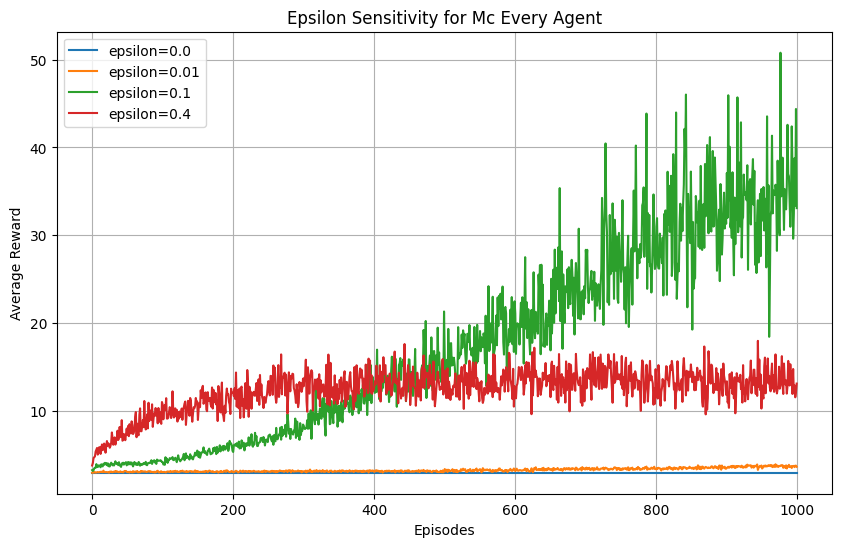

In [ ]:
# MC every visit agent
epsilon_experiment(agent_type='mc_every')

The plot above compares the performance of the **Monte Carlo Every-Visit agent** under different exploration rates (ε).

#### ✅ Conclusion:
An intermediate value like **ε = 0.1** strikes the best balance between exploration and exploitation, leading to the highest and most stable rewards.


Running sarsa_lambda with epsilon=0.0...


100%|██████████| 50/50 [00:04<00:00, 11.18it/s]


Running sarsa_lambda with epsilon=0.01...


100%|██████████| 50/50 [00:06<00:00,  7.35it/s]


Running sarsa_lambda with epsilon=0.1...


100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


Running sarsa_lambda with epsilon=0.4...


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


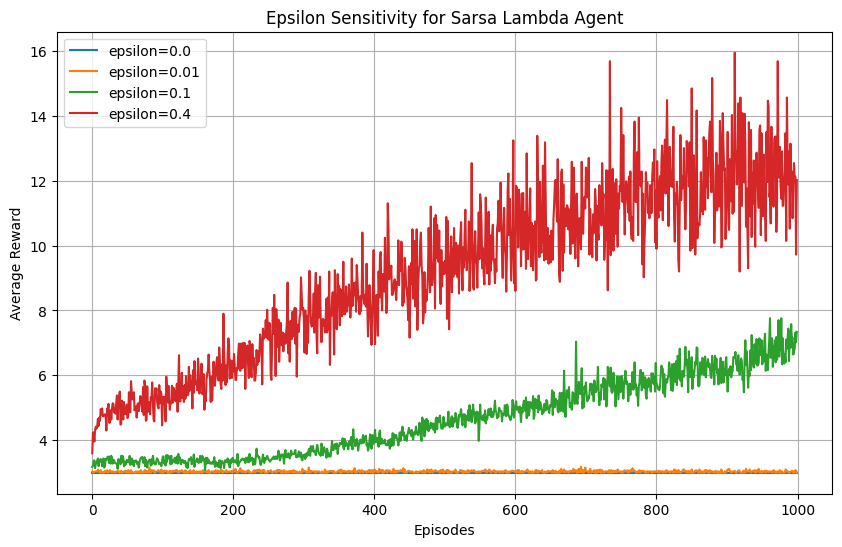

In [ ]:
# Sarsa(0) agent
epsilon_experiment(agent_type='sarsa_lambda', lambd=0)

This plot examines the effect of different exploration rates `ε` on the performance of the **Sarsa(λ) agent** when `λ = 0`, which corresponds to the standard one-step Sarsa (TD(0)).

- **ε = 0.0**: No exploration leads to poor performance. The agent quickly gets stuck in suboptimal behavior, as it never tries new actions.
- **ε = 0.01**: Marginal improvement over pure greedy behavior. The exploration rate is still too low to escape bad initial policies.
- **ε = 0.1**: Moderate improvement and more stable learning. The agent explores more effectively and improves gradually across episodes.
- **ε = 0.4**: Performs the best overall. The increased exploration helps the agent discover better policies and accumulate higher rewards, even if the variance is slightly higher.

#### ✅ Conclusion:
For `λ = 0`, a **higher exploration rate like ε = 0.4** significantly improves performance. Low ε values limit learning progress due to insufficient exploration.


Running sarsa_lambda with epsilon=0.0...


100%|██████████| 50/50 [00:05<00:00,  8.82it/s]


Running sarsa_lambda with epsilon=0.01...


100%|██████████| 50/50 [00:07<00:00,  6.36it/s]


Running sarsa_lambda with epsilon=0.1...


100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


Running sarsa_lambda with epsilon=0.4...


100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


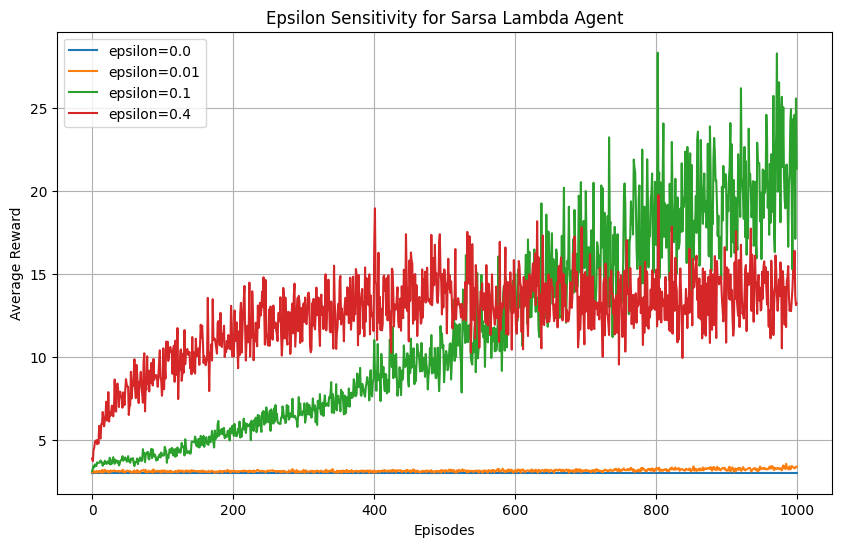

In [ ]:
# Sarsa(0.9) agent
epsilon_experiment(agent_type='sarsa_lambda', lambd=0.9)

This plot examines the effect of different exploration rates `ε` on the performance of the **Sarsa(λ) agent** when `λ = 0.9`.

#### ✅ Conclusion:
For `λ = 0.9`, an **exploration rate like ε = 0.1** significantly improves performance.


## c. Impact of λ (for Sarsa(λ))

Running sarsa_lambda with lambda=0.0...


100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


Running sarsa_lambda with lambda=0.3...


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


Running sarsa_lambda with lambda=0.6...


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


Running sarsa_lambda with lambda=0.9...


100%|██████████| 50/50 [01:24<00:00,  1.68s/it]


Running sarsa_lambda with lambda=1.0...


100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


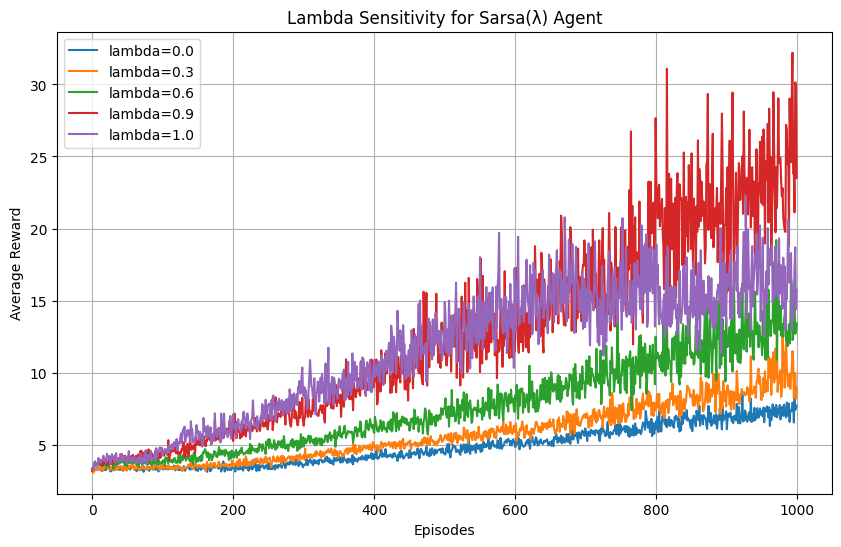

In [74]:
# Lambda sensitivity analysis for Sarsa(λ)
def lambda_experiment(lambdas=[0.0, 0.3, 0.6, 0.9, 1.0], episodes=1000, runs=50):
    results = {}
    for lambd in lambdas:
        print(f"Running sarsa_lambda with lambda={lambd}...")
        avg_rewards = np.zeros(episodes)
        for run in tqdm(range(runs)):
            env = make_env(height=6, width=10, pipe_gap=3, screen=False)
            agent = SarsaLambdaAgent(actions=[0, 1], lambd=lambd)
            rewards = agent.train(env, episodes=episodes)
            avg_rewards += np.array(rewards)

        avg_rewards /= runs
        results[lambd] = avg_rewards

    plt.figure(figsize=(10, 6))
    for lambd in results:
        plt.plot(results[lambd], label=f"lambda={lambd}")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title("Lambda Sensitivity for Sarsa(λ) Agent")
    plt.legend()
    plt.grid(True)
    plt.show()

lambda_experiment()

The plot above illustrates how the trace decay parameter `λ` influences the performance of the Sarsa(λ) agent over 1000 episodes.

- **λ = 0.0**: The agent reduces to standard TD(0) learning and learns slowly, with the lowest performance among all values tested.
- **λ = 0.3 / 0.6**: Increasing λ improves performance by allowing updates to credit earlier state-action pairs, but learning is still relatively conservative.
- **λ = 0.9**: This setting produces the best performance, combining long-term credit assignment with stable learning.
- **λ = 1.0**: Performance is strong but slightly below λ = 0.9. This may be due to higher variance from full-return updates, especially early in training.

#### ✅ Conclusion:
The best results are obtained for **λ = 0.9**, showing that eligibility traces significantly help propagate reward over time without the full variance of Monte Carlo-like returns.


## d. Conclusion for the different hyperparameters' values

* **MC First Agent**: α=0.5, ε=0.1
* **MC Every Agent**: α=0.5, ε=0.1
* **Sarsa(0)**: α=0.5 ,ε=0.4
* **Sarsa(0.9)**: α=0.5 ,ε=0.1

## VI. Comparison between best models

## a. Average reward

Evaluating best config for MC First...


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


Evaluating best config for MC Every...


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


Evaluating best config for Sarsa(0)...


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Evaluating best config for Sarsa(0.9)...


100%|██████████| 100/100 [04:25<00:00,  2.66s/it]


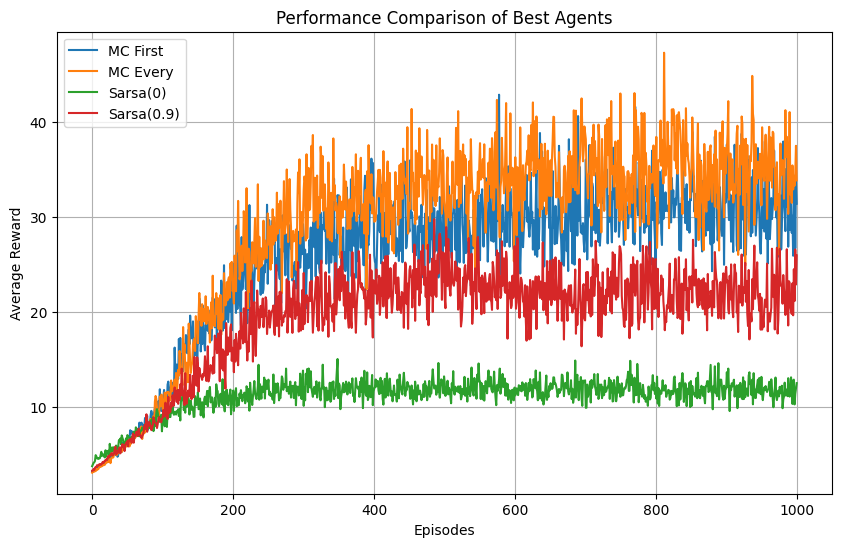

In [76]:
# Plot best agents comparison
def compare_best_agents(episodes=1000, runs=50):
    configs = {
        'MC First': lambda: MonteCarloAgent(actions=[0, 1], alpha=0.5, epsilon=0.1, first_visit=True),
        'MC Every': lambda: MonteCarloAgent(actions=[0, 1], alpha=0.5, epsilon=0.1, first_visit=False),
        'Sarsa(0)': lambda: SarsaLambdaAgent(actions=[0, 1], alpha=0.5, epsilon=0.4, lambd=0.0),
        'Sarsa(0.9)': lambda: SarsaLambdaAgent(actions=[0, 1], alpha=0.5, epsilon=0.1, lambd=0.9),
    }

    results = {name: np.zeros(episodes) for name in configs}

    for name, agent_fn in configs.items():
        print(f"Evaluating best config for {name}...")
        for _ in tqdm(range(runs)):
            env = make_env(height=6, width=10, pipe_gap=3, screen=False)
            agent = agent_fn()
            rewards = agent.train(env, episodes=episodes)
            results[name] += np.array(rewards)
        results[name] /= runs

    plt.figure(figsize=(10, 6))
    for name in results:
        plt.plot(results[name], label=name)
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title("Performance Comparison of Best Agents")
    plt.legend()
    plt.grid(True)
    plt.show()

compare_best_agents(episodes=1000, runs=100)

The plot shows the average episodic rewards of the four best-performing agents: MC First-Visit, MC Every-Visit, Sarsa(0), and Sarsa(λ=0.9), each trained over 1000 episodes and averaged across multiple runs.


#### Agent Differences

**1. Monte Carlo Agents (MC First vs MC Every)**:
- **MC Every** achieves the highest and most consistent average rewards across episodes.
- **MC First** performs similarly but slightly below MC Every, as it updates each (state, action) pair only once per episode, while MC Every leverages more data by updating every visit.
- **Convergence**: Both MC agents show relatively fast convergence (within ~200–300 episodes).
- **Sensitivity**: They are **sensitive to exploration rate ε** and benefit from moderate values (ε = 0.1).
- **Stability**: MC Every shows more reward variance due to more aggressive updates, but also higher peak performance.


**2. Sarsa Agents**:
- **Sarsa(0)** (TD(0)) is the worst-performing agent. Despite early learning, it plateaus at a much lower reward ceiling. This is likely due to its short-sighted one-step updates and need for more exploration (ε = 0.4).
- **Sarsa(0.9)** performs significantly better. It benefits from eligibility traces (λ = 0.9), which help propagate rewards backward over multiple steps, improving learning efficiency.
- **Convergence**: Sarsa(0.9) is slower to converge but more stable long-term.
- **Sensitivity**: Strongly influenced by both λ and ε.



#### ✅ Conclusion:
- **Best overall performer**: MC Every
- **Most stable with long-term learning**: Sarsa(λ = 0.9)
- **Fastest to converge**: MC agents
- **Most limited**: Sarsa(0), unless exploration is high and λ > 0


## b. Sate Value Function

In [95]:
def plot_state_value_function(agent_fn, model_name='Agent', episodes=1000, runs=50):
    """
    Plots the average state-value function V(s) = max_a Q(s,a) over multiple training runs.
    
    Parameters:
        agent_fn: A function that returns a new instance of the agent
        model_name: Name to display in the plot title
        episodes: Number of training episodes per run
        runs: Number of independent runs to average over
    """
    q_sums = defaultdict(lambda: np.zeros(2))
    q_counts = defaultdict(int)

    for _ in tqdm(range(runs), desc=f"Training {model_name}"):
        env = make_env(height=6, width=10, pipe_gap=3)
        agent = agent_fn()
        agent.train(env, episodes=episodes)
        for s in agent.Q:
            q_sums[s] += agent.Q[s]
            q_counts[s] += 1

    # Compute averaged Q-values and V(s)
    state_values = {}
    for s in q_sums:
        avg_q = q_sums[s] / q_counts[s]
        state_values[s] = np.max(avg_q)

    # Get axis ranges
    xs = sorted(set(s[0] for s in state_values if isinstance(s, tuple)))
    ys = sorted(set(s[1] for s in state_values if isinstance(s, tuple)))

    z = np.full((len(ys), len(xs)), np.nan)
    for i, y in enumerate(ys):
        for j, x in enumerate(xs):
            if (x, y) in state_values:
                z[i][j] = state_values[(x, y)]

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(z, xticklabels=xs, yticklabels=ys, cmap='viridis')
    plt.title(f"Avg State-Value Function: {model_name}\n({episodes} episodes, {runs} runs)")
    plt.xlabel("Horizontal Distance to Pipe")
    plt.ylabel("Vertical Offset from Gap")
    plt.tight_layout()
    plt.show()


Training MC First Visit: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s]


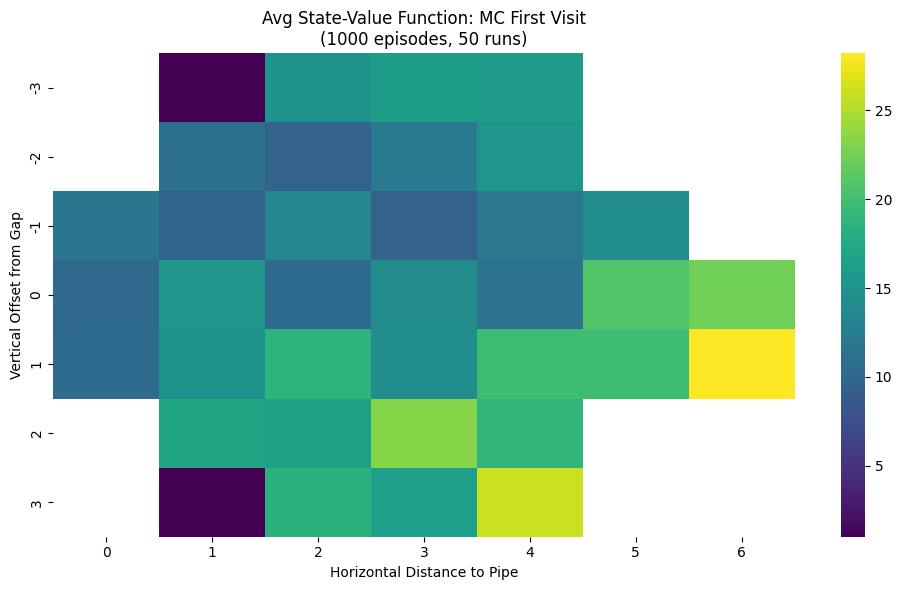

In [99]:
# MC first visit
plot_state_value_function(
    agent_fn=lambda: MonteCarloAgent(actions=[0, 1], alpha=0.5, epsilon=0.1, first_visit=True),
    model_name='MC First Visit',
    episodes=1000,
    runs=50
)


The heatmap visualizes the learned state-value function $ V(s) = \max_a Q(s, a) $  of the Monte Carlo First-Visit agent after training. Each cell corresponds to a specific state defined by:

- **x-axis**: Horizontal distance to the next pipe
- **y-axis**: Vertical offset from the center of the pipe gap


####  Observations:

- **Higher values** are concentrated in regions with **moderate horizontal distance (x = 4–6)** and **vertical offsets close to 0 or slightly positive**.
- This indicates that the agent has learned to assign high value to states where it is aligned with or just above the pipe gap and close to an obstacle — positions from which it can act optimally.
- **Low values** in areas where the agent is far from alignment (e.g., vertical offsets ±3) or too early in the scene (x ≈ 0–2), indicating poor expected return or early termination.


#### ✅ Conclusion:
The MC First-Visit agent successfully learns to value states that are close to the next pipe and properly aligned vertically, demonstrating a meaningful policy based on spatial positioning.


Training MC Every Visit: 100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


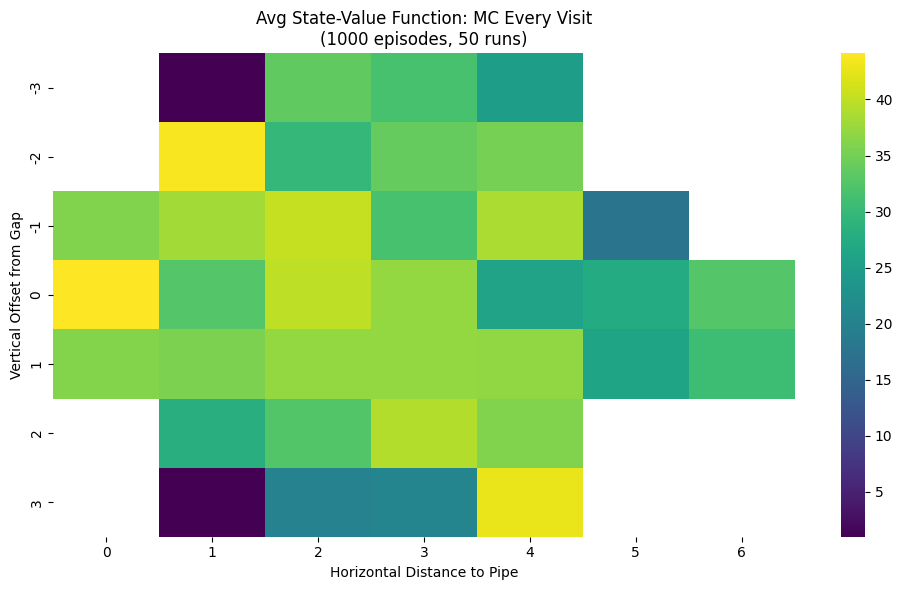

In [100]:
# MC every visit
plot_state_value_function(
    agent_fn=lambda: MonteCarloAgent(actions=[0, 1], alpha=0.5, epsilon=0.1, first_visit=False),
    model_name='MC Every Visit',
    episodes=1000,
    runs=50
)


This heatmap shows the average state-value function learned by the Monte Carlo Every-Visit agent. 

#### Observations:

- The value function is more **uniformly high** across a broader region compared to MC First-Visit.
- States where the vertical offset is close to zero and horizontal distance is between **x = 1 to 4** yield the highest values.
- Unlike MC First, this agent learns to assign high value **even when the pipe is farther**, suggesting a more general understanding of good positions.
- There's less sharp contrast between "good" and "bad" zones, implying smoother generalization.


#### ✅ Conclusion:
The MC Every-Visit agent provides a more generalized and optimistic estimate of the environment's value landscape, likely due to more frequent updates during training. This richer and broader understanding helps explain its stronger performance in reward plots.


Training Sarsa(λ = 0): 100%|██████████| 50/50 [00:58<00:00,  1.16s/it]


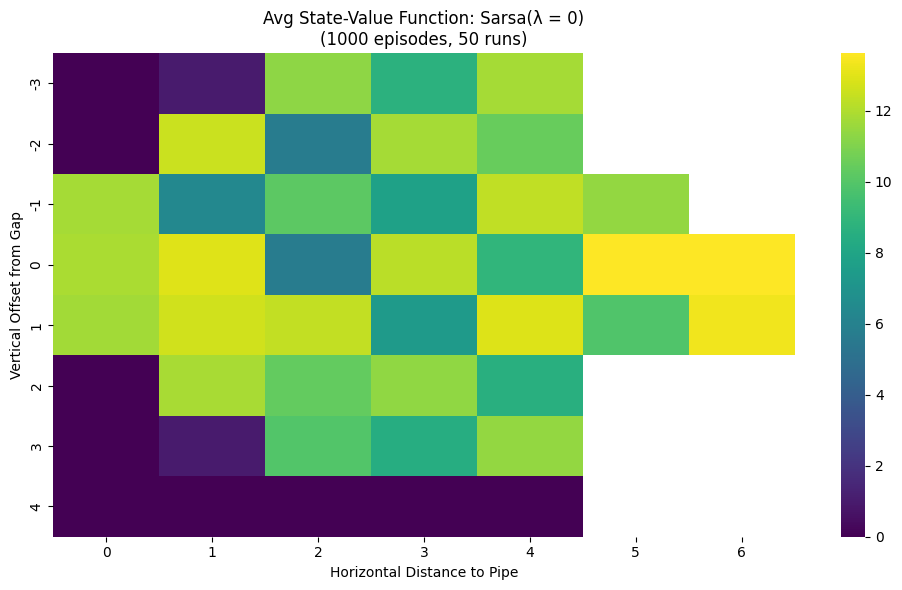

In [98]:
# Sarsa(0)
plot_state_value_function(
    agent_fn=lambda: SarsaLambdaAgent(actions=[0, 1], alpha=0.5, epsilon=0.4, lambd=0),
    model_name='Sarsa(λ = 0)',
    episodes=1000,
    runs=50
)


This heatmap displays the average state-value function learned by the Sarsa(0) agent using a one-step temporal-difference (TD) approach.

#### Observations:

- Value estimates are significantly lower overall compared to Monte Carlo agents, reflecting limited performance.
- High-value states are concentrated around the **centered vertical offset (−1 to +1)** and **moderate-to-high horizontal distances**, where the bird is better aligned and has time to act.
- Several corner states (e.g., edges and far vertical deviations) are poorly estimated or valued as 0, which may result from insufficient visits or early termination in these states.
- The map is more **sparse and abrupt**, showing limited generalization and coverage.


#### ✅ Conclusion:
Sarsa(0), while capable of learning local transitions, struggles to propagate long-term credit across multiple steps. This results in a more conservative and fragmented value map, consistent with its lower episodic reward performance.


Training Sarsa(λ = 0.9): 100%|██████████| 50/50 [01:31<00:00,  1.84s/it]


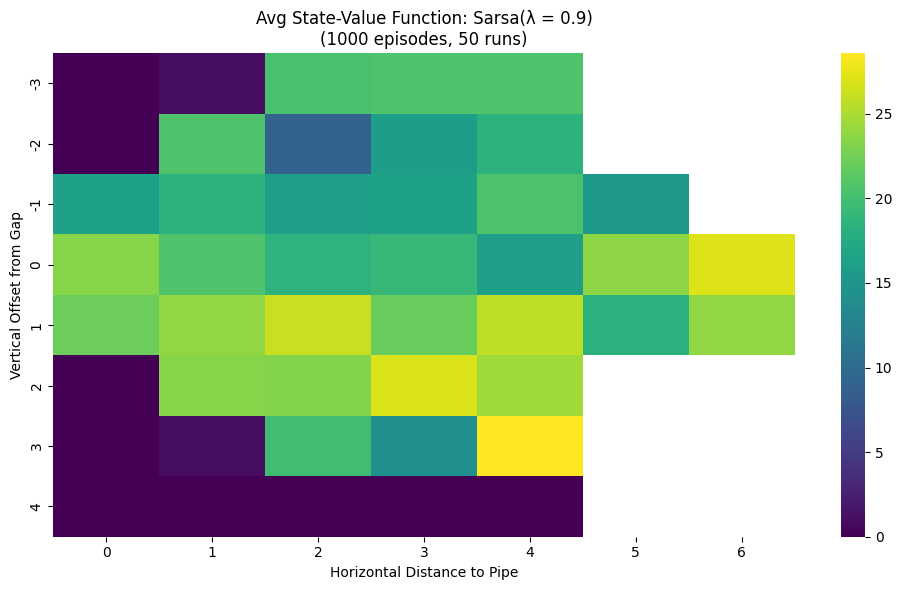

In [101]:
# Sarsa(0.9)
plot_state_value_function(
    agent_fn=lambda: SarsaLambdaAgent(actions=[0, 1], alpha=0.5, epsilon=0.1, lambd=0.9),
    model_name='Sarsa(λ = 0.9)',
    episodes=1000,
    runs=50
)


This heatmap visualizes the average state-value function learned by the Sarsa(λ = 0.9) agent. 

#### Observations:

- The agent assigns high value to states that are **close to the pipe (x = 4–6)** and **well-aligned vertically (y = 0 to +2)** — ideal positions for navigating through pipe gaps.
- Compared to Sarsa(0), this map is **much richer and smoother**, indicating improved generalization and credit assignment.
- The heatmap shows that eligibility traces allow the agent to better propagate value across sequences of decisions, especially in areas where anticipation of future reward matters.
- The low-value zones at the edges reflect poor or terminal states, often associated with crashes or unreachable pipes.


#### ✅ Conclusion:
Sarsa(λ = 0.9) learns a more complete and effective state-value representation than Sarsa(0), thanks to backward credit assignment via eligibility traces. This aligns with its higher reward performance and better policy behavior.


## VII. Impact of Configuration on best model

In [102]:
def evaluate_generalization(trained_agent, eval_configs, episodes=100, runs=20):
    """
    Evaluates a trained agent across different environment configurations.

    Args:
        trained_agent: a fully trained agent object (already trained)
        eval_configs: dict of environment configs {name: {height, width, pipe_gap}}
        episodes: number of episodes per run
        runs: how many full evaluations to average over

    Returns:
        results: dict of {env_name: (mean_reward, std_reward)}
    """
    results = {}

    for name, config in eval_configs.items():
        print(f"Evaluating on {name}...")
        run_rewards = []

        for _ in range(runs):
            env = make_env(**config)
            total_rewards = []

            for _ in range(episodes):
                _, total_reward = run_episode(env, trained_agent, train=False)
                total_rewards.append(total_reward)

            run_rewards.append(np.mean(total_rewards))

        mean_reward = np.mean(run_rewards)
        std_reward = np.std(run_rewards)
        results[name] = (mean_reward, std_reward)
        print(f"{name}: Avg Reward = {mean_reward:.2f} ± {std_reward:.2f}")

    return results


In [103]:
def plot_generalization_results(results, title="Generalization Across Configs"):
    labels = list(results.keys())
    means = [results[k][0] for k in labels]
    stds = [results[k][1] for k in labels]

    plt.figure(figsize=(10, 5))
    plt.bar(labels, means, yerr=stds, capsize=5, color='skyblue')
    plt.ylabel("Average Reward")
    plt.title(title)
    plt.xticks(rotation=15)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


Evaluating on Smaller Height...
Smaller Height: Avg Reward = 46.65 ± 7.48
Evaluating on Larger Height...
Larger Height: Avg Reward = 37.07 ± 4.01
Evaluating on Smaller width...
Smaller width: Avg Reward = 27.81 ± 2.27
Evaluating on Larger width...
Larger width: Avg Reward = 65.33 ± 6.75
Evaluating on Smaller Gap...
Smaller Gap: Avg Reward = 14.53 ± 0.72
Evaluating on Larger Gap...
Larger Gap: Avg Reward = 67.26 ± 7.46


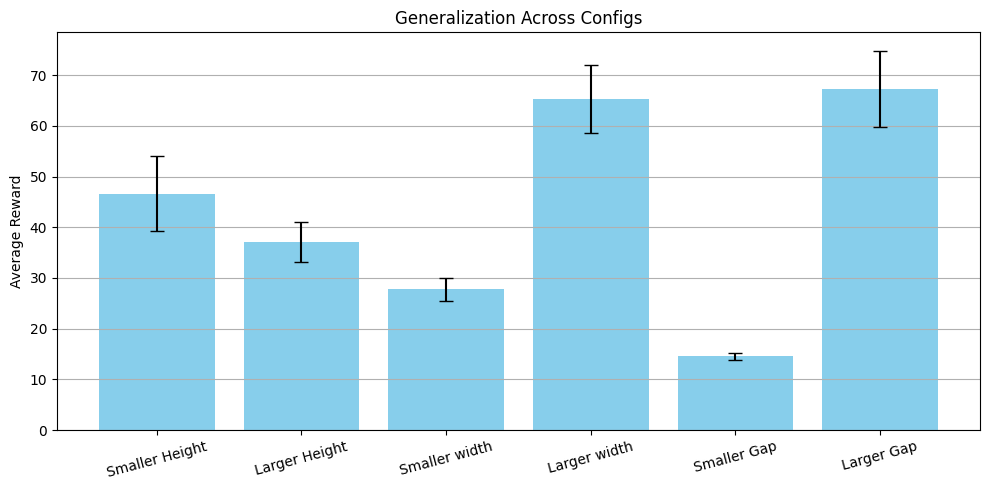

In [111]:
# Train the best agent
train_env = make_env(height=15, width=20, pipe_gap=4)
agent = MonteCarloAgent(actions=[0, 1], alpha=0.5, epsilon=0.1, first_visit=False)
agent.train(train_env, episodes=1000)

# Test environments
eval_envs = {
    "Smaller Height": {"height": 10, "width": 20, "pipe_gap": 4},
    "Larger Height": {"height": 20, "width": 20, "pipe_gap": 4},
    "Smaller width": {"height": 15, "width": 10, "pipe_gap": 4},
    "Larger width": {"height": 15, "width": 20, "pipe_gap": 4},
    "Smaller Gap": {"height": 15, "width": 20, "pipe_gap": 2},
    "Larger Gap": {"height": 15, "width": 20, "pipe_gap": 4},
}

# Evaluate and plot
results = evaluate_generalization(agent, eval_envs, episodes=100, runs=20)
plot_generalization_results(results)


This plot compares the MC Every-Visit agent's performance on a variety of environment configurations, using the same trained policy from the baseline setup (`height=15`, `width=20`, `pipe_gap=4`). Rewards are averaged over multiple evaluation runs, with error bars representing the standard deviation.



#### Height Modifications

- **Smaller Height**: The agent performs strongly with a high average reward and moderate variance. The reduced vertical space doesn't hinder the learned policy significantly and may even simplify the game by constraining the movement range.
- **Larger Height**: Performance drops slightly compared to the smaller height setup. The increased vertical space introduces more room for error, especially if the agent was trained in a more compact vertical range.

✅ **Conclusion**: The agent generalizes decently to both height changes, with better adaptation to smaller vertical bounds.



#### Width Modifications

- **Smaller Width**: Performance declines notably. The reduced horizontal space offers less time for the agent to react between pipes, breaking its timing-based policy and resulting in lower rewards.
- **Larger Width**: The agent performs exceptionally well here — even better than the baseline. The increased width gives more reaction time and smoother transitions between obstacles, allowing the learned policy to succeed more reliably.

✅ **Conclusion**: The agent generalizes poorly to narrower widths but excels in wider ones, benefiting from longer decision windows.



#### Gap Modifications

- **Smaller Gap**: The most challenging configuration. The agent performs poorly here, with both low rewards and low variance. This indicates a consistent failure due to tighter navigation space — the agent likely crashes frequently.
- **Larger Gap**: The highest-performing configuration. The easier task makes the learned policy highly effective, even if slightly misaligned. The agent performs reliably and achieves high rewards.

✅ **Conclusion**: The agent struggles when the pipe gap is narrower than during training but thrives when the gap is larger.


#### ✅ Final Insight

The MC Every-Visit agent shows **strong generalization** to configurations that make the environment **more forgiving** (larger width/gap), but suffers under **tighter constraints** (narrower pipes or width). This highlights the need for retraining or function approximation when transferring agents to more difficult levels.
